<center>

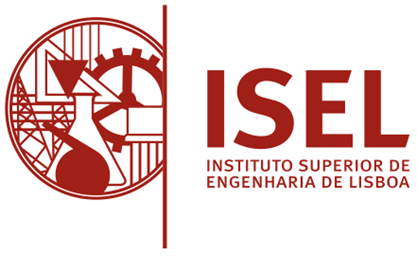
<h2>
Instituto Superior de Engenharia de Lisboa

Licenciatura Engenharia Informática e Multimédia

Ano letivo 2024/2025

Aprendizagem Automática

Trabalho concretizado pelos alunos:

Benjamim Noronha nº50731

Gonçalo Clementino nº50736

Fransisco Sousa nº 50795


Docente: Gonçalo Silva

<h2>

29 de dezembro de 2024
</center>



## Introdução mudar

<h4>
No ambito da unidade curricular Aprendizagem automática, realizou o 2º trabalho prático, em que predente-se cumprir os objetivos propostos.

Estes objetivos são: Dado um ficheiro com as criticas de cinema e as notas atribuidas pelos utilizadores (de 1 a 4 e 7 a 10) do site IMDb, precisamos de: treinar um classificador multi-classe, de maneira a prever a nota da critica em base do texto da critica; treinar e avaliar um regressor que este prevê a pontuação da critica; e fazer clustering das críticas.

Neste trabalho será utilizado os classificadores RandomForestClassifier (como pedido no enunciado), Logistic Regression e Support Vetor Machine, para conseguir escolher os melhores híper parametros usou-se o modelo GridSearch e para o pré-processamento de dados usou-se o StandarScaler.
</h4>

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import re
from nltk.stem import SnowballStemmer, PorterStemmer, LancasterStemmer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import sklearn.preprocessing as pp
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, confusion_matrix, silhouette_score
from sklearn.cluster import KMeans

from plotMatriz import plotMatriz

#### Carrega-se os dados do IMDb

In [28]:
file = open("imdbFull.p", "rb")
dados = pickle.load(file)

In [29]:
print(dados.keys())

dict_keys(['data', 'target', 'DESCR'])


#### Os dados ficam divididos em criticas de texto e as respetivas pontuações

In [30]:
Docs = dados['data']
y = dados['target']
des = dados['DESCR']
des

'This dataset contains movie reviews along with their associated binary sentiment polarity labels. It is intended to serve as a benchmark for sentiment classification. This document outlines how the dataset was gathered, and how to use the files provided.\nFor more details see: http://ai.stanford.edu/~amaas/data/sentiment/'

#### Observa-se que o tipo de dado da critica já esta em string

In [31]:
print(type(Docs[1]))
print(Docs[0])

<class 'str'>
Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty.


#### 15 a 20 segundos o tfidf
## Construção do vocabulário

<h4> 
Nesta etapa constroi-se o vocabulário, importante para melhorar o desempenho dos modelos, seja de classificação ou regressão, onde será necessario também de existir uma limpeza nos textos das criticas, de maneira a diminuir o ruído de palavras e dar relevancia maior a certas palavras, assim como deixar o algoritmo dos modelos mais rapidos pela diminuição das palavras.


Acontece uma limpeza nas criticas, onde elimina-se as tags br de break, e torna a string em unicode.
Seguidamente, aplica-se um filtro, limpando mais o vocabulario, em que só conta palavras de 4 letras ou mais que apareçam em pelo menos 5 criticas.

In [32]:
# Docs1 = [doc.decode('UTF-8') for doc in Docs_ps] #ja estão em str, n é byte
Docs_normal = [doc.replace('<br />', ' ') for doc in Docs]
Docs_normal = [re.sub(r'[^a-zA-Z]+', ' ', doc) for doc in Docs_normal]

print(Docs_normal[1])

tfidf = TfidfVectorizer(
    min_df=5, token_pattern=r'\b\w\w\w+\b').fit(Docs_normal)
X_ws = tfidf.transform(Docs_normal)

Words can t describe how bad this movie is I can t explain it by writing only You have too see it for yourself to get at grip of how horrible a movie really can be Not that I recommend you to do that There are so many clich s mistakes and all other negative things you can imagine here that will just make you cry To start with the technical first there are a LOT of mistakes regarding the airplane I won t list them here but just mention the coloring of the plane They didn t even manage to show an airliner in the colors of a fictional airline but instead used a painted in the original Boeing livery Very bad The plot is stupid and has been done many times before only much much better There are so many ridiculous moments here that i lost count of it really early Also I was on the bad guys side all the time in the movie because the good guys were so stupid Executive Decision should without a doubt be you re choice over this one even the Turbulence movies are better In fact every other movie 

#### Acontece a separação do texto de criticas, em dados de treino e teste, além disso, faz-se um pre-processamento de dados (sem média) para verificar se melhora os resultados ao pré processar os dados

In [33]:
X_ws1, X_ws2, ytreino, yteste = train_test_split(
    X_ws, y, test_size=0.2, random_state=0
)
sc = pp.StandardScaler(with_mean=False)
sc1 = sc.fit(X_ws1)

XtreinoN = sc1.transform(X_ws1)
XtesteN = sc1.transform(X_ws2)

<h4>
Usou-se a regressão logistica como classificador, o objetivo nesta etapa não é classificar mas sim, usando um classificador simples, observar por alto a pontuação do classificador para os dados de treino e teste, e comparar esta pontuação com a pontuação dada usando o pré-processamento de dados

Verifica-se que utilizar o pré-processamento de dados piorou bastante o classificador, onde é evidente o overfit, isso é, maior pontuação nos dados de treino mas com uma grande diferença na pontuação de treino com teste, onde a pontuação dos dados de teste são piores.

In [34]:
dl = LogisticRegression(max_iter=1000, random_state=0).fit(X_ws1, ytreino)
print(dl.score(X_ws1, ytreino), "de score de treino")
print(dl.score(X_ws2, yteste), "de score de teste")

0.66945 de score de treino
0.4418 de score de teste


In [35]:
dl = LogisticRegression(max_iter=1000, random_state=0).fit(XtreinoN, ytreino)
print(dl.score(XtreinoN, ytreino), "de score de treino")
print(dl.score(XtesteN, yteste), "de score de teste")

0.999875 de score de treino
0.3582 de score de teste


In [36]:
stemFunc = PorterStemmer()

# Docs1 = [doc.decode('UTF-8') for doc in Docs_ps] #ja estão em str, n é byte
Docs_ps = [''.join(stemFunc.stem(d)) for d in Docs_normal]

print(Docs_ps[1])

tfidf_ps = TfidfVectorizer(
    min_df=5, token_pattern=r'\b\w\w\w+\b').fit(Docs_ps)
X_ps = tfidf_ps.transform(Docs_ps)

words can t describe how bad this movie is i can t explain it by writing only you have too see it for yourself to get at grip of how horrible a movie really can be not that i recommend you to do that there are so many clich s mistakes and all other negative things you can imagine here that will just make you cry to start with the technical first there are a lot of mistakes regarding the airplane i won t list them here but just mention the coloring of the plane they didn t even manage to show an airliner in the colors of a fictional airline but instead used a painted in the original boeing livery very bad the plot is stupid and has been done many times before only much much better there are so many ridiculous moments here that i lost count of it really early also i was on the bad guys side all the time in the movie because the good guys were so stupid executive decision should without a doubt be you re choice over this one even the turbulence movies are better in fact every other movie 

In [37]:
X_ps1, X_ps2, ytreino_ps, yteste_ps = train_test_split(
    X_ps, y, test_size=0.2, random_state=0
)

In [38]:
dl = LogisticRegression(max_iter=1000, random_state=0).fit(X_ps1, ytreino_ps)
print(dl.score(X_ps1, ytreino_ps), "de score de treino")
print(dl.score(X_ps2, yteste_ps), "de score de teste")

0.67605 de score de treino
0.4413 de score de teste


In [39]:
stemFunc = SnowballStemmer(language='english')

# Docs1 = [doc.decode('UTF-8') for doc in Docs_ss] #ja estão em str, n é byte
Docs_ss = [''.join(stemFunc.stem(d)) for d in Docs_normal]

print(Docs_ss[1])

tfidf_ss = TfidfVectorizer(
    min_df=5, token_pattern=r'\b\w\w\w+\b').fit(Docs_ss)
X_ss = tfidf_ss.transform(Docs_ss)

words can t describe how bad this movie is i can t explain it by writing only you have too see it for yourself to get at grip of how horrible a movie really can be not that i recommend you to do that there are so many clich s mistakes and all other negative things you can imagine here that will just make you cry to start with the technical first there are a lot of mistakes regarding the airplane i won t list them here but just mention the coloring of the plane they didn t even manage to show an airliner in the colors of a fictional airline but instead used a painted in the original boeing livery very bad the plot is stupid and has been done many times before only much much better there are so many ridiculous moments here that i lost count of it really early also i was on the bad guys side all the time in the movie because the good guys were so stupid executive decision should without a doubt be you re choice over this one even the turbulence movies are better in fact every other movie 

In [40]:
X_ss1, X_ss2, ytreino_ss, yteste_ss = train_test_split(
    X_ss, y, test_size=0.2, random_state=0
)

In [41]:
dl = LogisticRegression(max_iter=1000, random_state=0).fit(X_ss1, ytreino_ss)
print(dl.score(X_ss1, ytreino_ss), "de score de treino")
print(dl.score(X_ss2, yteste_ss), "de score de teste")

0.674725 de score de treino
0.4415 de score de teste


In [42]:
stemFunc = LancasterStemmer()

# Docs_ls1 = [doc.decode('UTF-8') for doc in Docs_ls] #ja estão em str, n é byte
Docs_ls = [''.join(stemFunc.stem(d)) for d in Docs_normal]

print(Docs_ls[1])

tfidf_ls = TfidfVectorizer(
    min_df=5, token_pattern=r'\b\w\w\w+\b').fit(Docs_ls)
X_ls = tfidf_ls.transform(Docs_ls)

words can t describe how bad this movie is i can t explain it by writing only you have too see it for yourself to get at grip of how horrible a movie really can be not that i recommend you to do that there are so many clich s mistakes and all other negative things you can imagine here that will just make you cry to start with the technical first there are a lot of mistakes regarding the airplane i won t list them here but just mention the coloring of the plane they didn t even manage to show an airliner in the colors of a fictional airline but instead used a painted in the original boeing livery very bad the plot is stupid and has been done many times before only much much better there are so many ridiculous moments here that i lost count of it really early also i was on the bad guys side all the time in the movie because the good guys were so stupid executive decision should without a doubt be you re choice over this one even the turbulence movies are better in fact every other movie 

In [43]:
X_ls1, X_ls2, ytreino_ls, yteste_ls = train_test_split(
    X_ls, y, test_size=0.2, random_state=0
)

In [44]:
dl = LogisticRegression(max_iter=1000, random_state=0).fit(X_ls1, ytreino_ls)
print(dl.score(X_ls1, ytreino_ls), "de score de treino")
print(dl.score(X_ls2, yteste_ls), "de score de teste")

0.6768 de score de treino
0.4415 de score de teste


### 20 min o gridsearch

In [45]:
""" param_grid_logreg = {
    'C': np.arange(0.1, 1.3, 0.1),
    'penalty': np.array(['l1', 'l2']),
    'solver': np.array(['saga', 'lbfgs'])

}
grid_search_logreg = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=0), param_grid_logreg, n_jobs=-1)
grid_search_logreg.fit(X_ss1, ytreino_ss)
logreg_params = grid_search_logreg.best_params_
print("Best Parameters:", logreg_params)
print("Best Score:", grid_search_logreg.best_score_) """

' param_grid_logreg = {\n    \'C\': np.arange(0.1, 1.3, 0.1),\n    \'penalty\': np.array([\'l1\', \'l2\']),\n    \'solver\': np.array([\'saga\', \'lbfgs\'])\n\n}\ngrid_search_logreg = GridSearchCV(\n    LogisticRegression(max_iter=1000, random_state=0), param_grid_logreg, n_jobs=-1)\ngrid_search_logreg.fit(X_ss1, ytreino_ss)\nlogreg_params = grid_search_logreg.best_params_\nprint("Best Parameters:", logreg_params)\nprint("Best Score:", grid_search_logreg.best_score_) '

In [46]:
logreg_params = {'C': np.float64(
    0.9), 'penalty': np.str_('l2'), 'solver': 'saga'}

In [47]:
classes = np.array([1, 2, 3, 4, 7, 8, 9, 10])

5884 erros
43.71 de score de treino
41.16 de score de teste


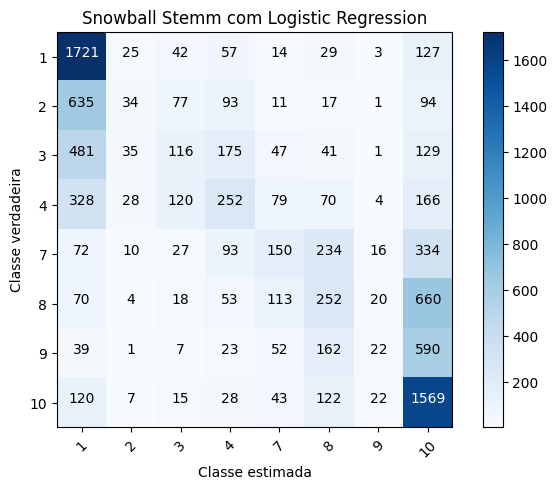

In [ ]:
dl = LogisticRegression(**logreg_params, max_iter=1000,
                        random_state=0).fit(X_ss1, ytreino_ss)

predict_dl = cross_val_predict(dl, X_ss2, yteste_ss)
print(np.sum(predict_dl != yteste_ss), "erros")
cm = confusion_matrix(yteste_ss, predict_dl)


plotMatriz(cm, classes=classes, title="Snowball Stemm com Logistic Regression")

# print(dl.score(X_ss1, ytreino_ss))
print(np.round(np.mean(cross_val_score(dl, X_ss1, ytreino_ss))*100, 2),
      "de score de treino")
# print(dl.score(X_ss2, yteste_ss))
print(np.round(np.mean(cross_val_score(dl, X_ss2, yteste_ss))*100, 2),
      "de score de teste")

In [49]:
tfidf_ss_bi = TfidfVectorizer(
    min_df=5, token_pattern=r'\b\w\w\w+\b', ngram_range=(1, 2)).fit(Docs_ss)
X_ss_bi = tfidf_ss_bi.transform(Docs_ss)

In [50]:
X_ss1_bi, X_ss2_bi, ytreino_ss_bi, yteste_ss_bi = train_test_split(
    X_ss_bi, y, test_size=0.2, random_state=0
)

6007 erros
44.28 de score de treino
39.93 de score de teste


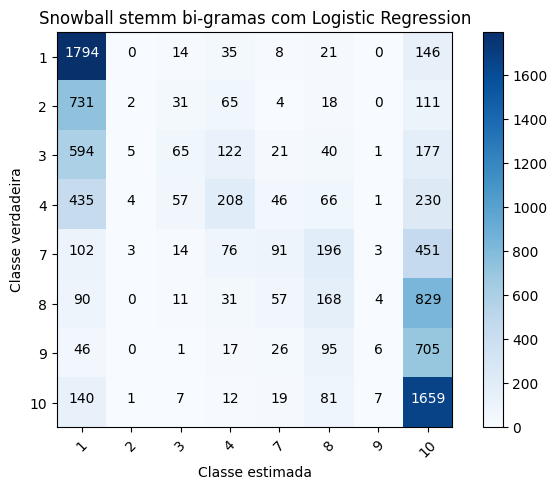

In [ ]:
dl = LogisticRegression(**logreg_params, max_iter=1000,
                        random_state=0).fit(X_ss1_bi, ytreino_ss_bi)

predict_dl = cross_val_predict(dl, X_ss2_bi, yteste_ss_bi)
print(np.sum(predict_dl != yteste_ss_bi), "erros")
cm = confusion_matrix(yteste_ss_bi, predict_dl)
plotMatriz(cm, classes=classes,
           title="Snowball stemm bi-gramas com Logistic Regression")


print(np.round(np.mean(cross_val_score(dl, X_ss1_bi, ytreino_ss_bi))
      * 100, 2), "de score de treino")
print(np.round(np.mean(cross_val_score(dl, X_ss2_bi, yteste_ss_bi))
      * 100, 2), "de score de teste")

In [52]:
""" dl = svm.SVC(C=1, tol=1e-3, gamma='auto').fit(X_ss1, ytreino)
print(dl.score(X_ss1, ytreino))
print(dl.score(X_ss2, yteste)) """

" dl = svm.SVC(C=1, tol=1e-3, gamma='auto').fit(X_ss1, ytreino)\nprint(dl.score(X_ss1, ytreino))\nprint(dl.score(X_ss2, yteste)) "

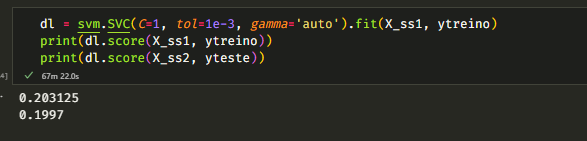

In [53]:
from sklearn.linear_model import Ridge, Lasso

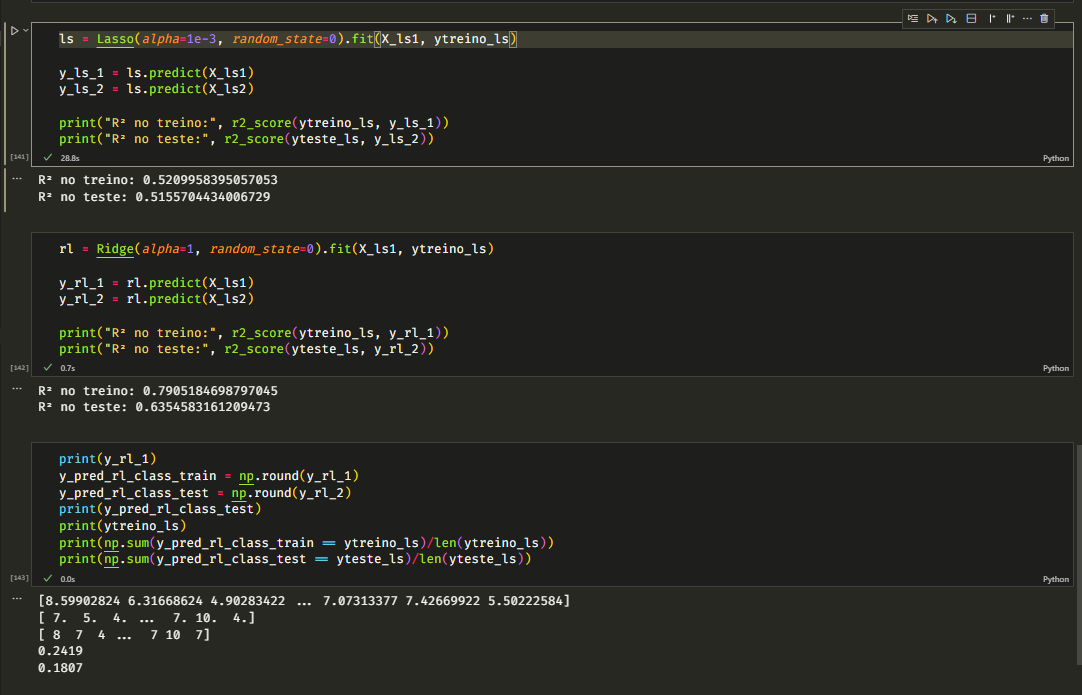

### 1 min

In [54]:
param_grid_lasso = {
    'alpha': np.array([1e-3, 1e-2, 1e-1, 1, 10])
}


grid_search_lasso = GridSearchCV(
    Lasso(random_state=0),  param_grid_lasso, n_jobs=-1
)
grid_search_lasso.fit(X_ss1, ytreino_ss)

lasso_params = grid_search_lasso.best_params_
print("Melhor valor de alpha:", lasso_params)
print("Melhor score de validação cruzada (R²):", grid_search_lasso.best_score_)

Melhor valor de alpha: {'alpha': np.float64(0.001)}
Melhor score de validação cruzada (R²): 0.5141856327185736


In [55]:
las = Lasso(**lasso_params, random_state=0).fit(X_ss1, ytreino_ss)

y_las_1 = las.predict(X_ss1)
y_las_2 = las.predict(X_ss2)

print("R² no treino:", r2_score(ytreino_ss, y_las_1))
print("R² no teste:", r2_score(yteste_ss, y_las_2))


print("Erro médio absoluto (MAE) no teste:",
      mean_absolute_error(yteste_ss, y_las_2))
print("Erro médio quadrático (MSE) no teste:",
      mean_squared_error(yteste_ss, y_las_2))

R² no treino: 0.5211519813079928
R² no teste: 0.5157095345413868
Erro médio absoluto (MAE) no teste: 2.0282909106349254
Erro médio quadrático (MSE) no teste: 5.855850461620186


[7.66473861 5.11916464 5.23210143 ... 6.54940054 8.04124777 5.86160087]
[8. 4. 4. ... 7. 8. 7.]
[ 8  7  4 ...  7 10  7]
0.2166
7834 erros


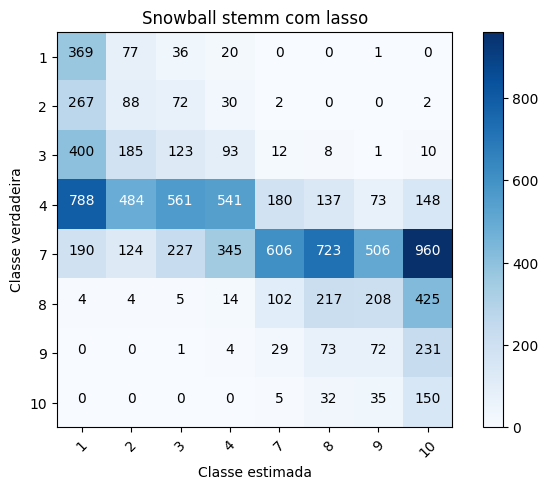

In [56]:
print(y_las_2)
y_pred_las_class_test = np.round(y_las_2)
y_pred_las_class_test[y_pred_las_class_test > 10.] = 10.
y_pred_las_class_test[y_pred_las_class_test < 1.] = 1.
y_pred_las_class_test[y_pred_las_class_test == 5.] = 4.
y_pred_las_class_test[y_pred_las_class_test == 6.] = 7.

print(y_pred_las_class_test)
print(ytreino_ss)
print(np.sum(y_pred_las_class_test == yteste_ss)/len(yteste_ss))

print(np.sum(y_pred_las_class_test != yteste_ss), "erros")
cm = confusion_matrix(y_pred_las_class_test, yteste_ss)
plotMatriz(cm, classes=classes, title="Snowball stemm com lasso")

### quase 1 min

In [57]:
param_grid_ridge = {
    # Altere os valores de alpha conforme necessário
    'alpha': np.array([1e-3, 1e-2, 1e-1, 1, 10])
}

# Configurando o GridSearchCV
grid_search_ridge = GridSearchCV(
    Ridge(random_state=0),  param_grid_ridge, n_jobs=-1
)

# Ajustando o modelo
grid_search_ridge.fit(X_ss1, ytreino_ss)

# Obtendo os melhores parâmetros e score
ridge_params = grid_search_ridge.best_params_
print("Melhor valor de alpha:", ridge_params)
print("Melhor score de validação cruzada (R²):", grid_search_ridge.best_score_)

Melhor valor de alpha: {'alpha': np.float64(1.0)}
Melhor score de validação cruzada (R²): 0.6345689362092422


In [58]:
rl = Ridge(**ridge_params, random_state=0).fit(X_ss1, ytreino_ss)

y_rl_1 = rl.predict(X_ss1)
y_rl_2 = rl.predict(X_ss2)

print("R² no treino:", r2_score(ytreino_ss, y_rl_1))
print("R² no teste:", r2_score(yteste_ss, y_rl_2))

print("Erro médio absoluto (MAE) no teste:",
      mean_absolute_error(yteste_ss, y_rl_2))
print("Erro médio quadrático (MSE) no teste:",
      mean_squared_error(yteste_ss, y_rl_2))

R² no treino: 0.7903894648219885
R² no teste: 0.6352915622512411
Erro médio absoluto (MAE) no teste: 1.6792156563523997
Erro médio quadrático (MSE) no teste: 4.40991145990331


[ 6.55974131  4.98117111  4.23679895 ...  7.28499069 10.22590239
  4.06236578]
[ 7.  4.  4. ...  7. 10.  4.]
[ 8  7  4 ...  7 10  7]
0.2679
7321 erros


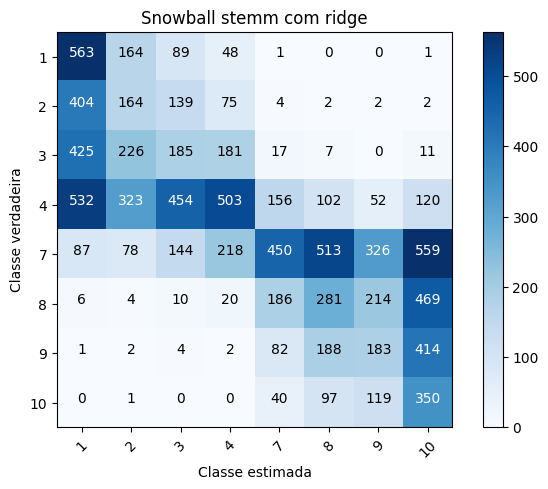

In [59]:
print(y_rl_2)
y_pred_rl_class_test = np.round(y_rl_2)
y_pred_rl_class_test[y_pred_rl_class_test > 10.] = 10.
y_pred_rl_class_test[y_pred_rl_class_test < 1.] = 1.
y_pred_rl_class_test[y_pred_rl_class_test == 5.] = 4.
y_pred_rl_class_test[y_pred_rl_class_test == 6.] = 7.

print(y_pred_rl_class_test)
print(ytreino_ss)
print(np.sum(y_pred_rl_class_test == yteste_ss)/len(yteste_ss))

print(np.sum(y_pred_rl_class_test != yteste_ss), "erros")
cm = confusion_matrix(y_pred_rl_class_test, yteste_ss)
plotMatriz(cm, classes=classes, title="Snowball stemm com ridge")

In [60]:
from sklearn.linear_model import LinearRegression

In [61]:
model = LinearRegression(n_jobs=-1).fit(X_ss1, ytreino_ss)

y_pred_lr_train = model.predict(X_ss1)
y_pred_lr_test = model.predict(X_ss2)

print("R² no treino:", r2_score(ytreino_ss, y_pred_lr_train))
print("R² no teste:", r2_score(yteste_ss, y_pred_lr_test))

print("Erro médio absoluto (MAE) no teste:",
      mean_absolute_error(yteste_ss, y_pred_lr_test))
print("Erro médio quadrático (MSE) no teste:",
      mean_squared_error(yteste_ss, y_pred_lr_test))

R² no treino: 0.9743578050865203
R² no teste: -6.0051894046834455
Erro médio absoluto (MAE) no teste: 6.661386313740214
Erro médio quadrático (MSE) no teste: 84.70400417713368


[ 5.22184184 10.27470802  1.09184692 ...  0.09567631  5.63794663
 -3.07229441]
[ 4. 10.  1. ...  1.  7.  1.]
[ 4. 10.  1. ...  1.  7.  1.]
[ 8  7  4 ...  7 10  7]
0.2255
7745 erros


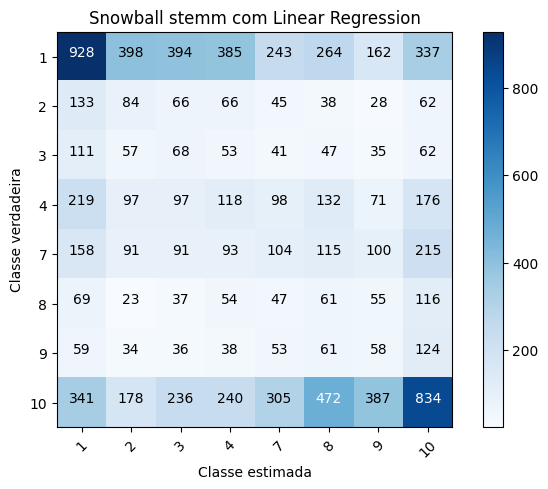

In [62]:
print(y_pred_lr_test)
y_pred_lr_class_test = np.round(y_pred_lr_test)
y_pred_lr_class_test[y_pred_lr_class_test > 10.] = 10.
y_pred_lr_class_test[y_pred_lr_class_test < 1.] = 1.
y_pred_lr_class_test[y_pred_lr_class_test == 5.] = 4.
y_pred_lr_class_test[y_pred_lr_class_test == 6.] = 7.
print(y_pred_lr_class_test)

print(y_pred_lr_class_test)
print(ytreino_ss)
print(np.sum(y_pred_lr_class_test == yteste_ss)/len(yteste_ss))

print(np.sum(y_pred_lr_class_test != yteste_ss), "erros")
cm = confusion_matrix(y_pred_lr_class_test, yteste_ss)
plotMatriz(cm, classes=classes, title="Snowball stemm com Linear Regression")

## Cluster

Número de clusters: 2, Silhouette Score: 0.0038
Número de clusters: 3, Silhouette Score: -0.0019
Número de clusters: 4, Silhouette Score: -0.0018
Número de clusters: 5, Silhouette Score: -0.0030


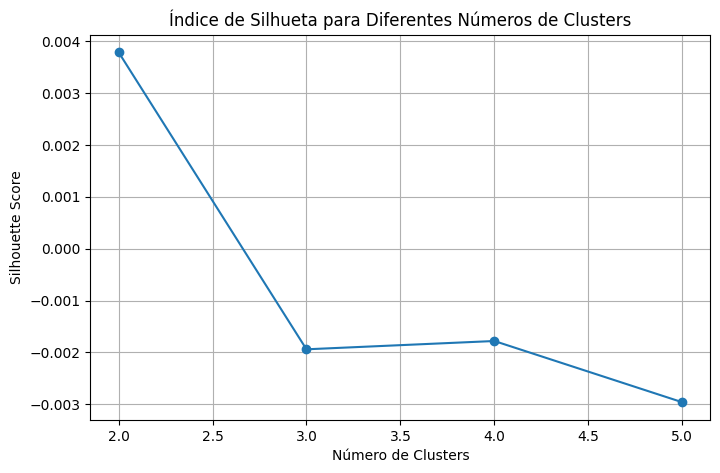

In [63]:
# Definindo diferentes números de clusters para análise
cluster_range = range(2, 6)
silhouette_scores = []

for n_clusters in cluster_range:
    # Modelo K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=9)
    kmeans.fit(X_ws)

    # Avaliação com índice de silhueta
    score = silhouette_score(X_ws, kmeans.labels_)
    silhouette_scores.append(score)

    print(f"Número de clusters: {n_clusters}, Silhouette Score: {score:.4f}")

# Plotando o índice de silhueta para diferentes valores de clusters
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title("Índice de Silhueta para Diferentes Números de Clusters")
plt.xlabel("Número de Clusters")
plt.ylabel("Silhouette Score")
plt.grid()
plt.show()

In [64]:
# Selecionando o número de clusters ideal (exemplo: 4 clusters)
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
kmeans.fit(X_ws)

# Atribuindo os rótulos aos documentos
Docs_clusters = {i: [] for i in range(optimal_clusters)}
for idx, label in enumerate(kmeans.labels_):
    Docs_clusters[label].append(Docs_normal[idx])

# Analisando os tópicos em cada cluster
for cluster, docs in Docs_clusters.items():
    print(f"\nCluster {cluster}: {len(docs)} documentos")
    print("Exemplo de críticas:")
    for doc in docs[:3]:  # Exibindo 3 exemplos por cluster
        print(f"- {doc[:150]}...")  # Mostrando os primeiros 150 caracteres


Cluster 0: 3990 documentos
Exemplo de críticas:
-  Show People is an absolutely delightful silent directed by King Vidor and starring Marion Davies and Billy Haines What gems both of them are in this ...
- On first watching this film it is hard to know quite what has happened but on a subsequent viewing it become more clear I enjoyed this movie Dean Cain...
- I love a good sappy love story and I m a guy but when I rented Love Story I prayed for the end to come as quickly and painlessly as possible and just ...

Cluster 1: 19599 documentos
Exemplo de críticas:
- Zero Day leads you to think even re think why two boys young men would do what they did commit mutual suicide via slaughtering their classmates It cap...
- The Movie was sub par but this Television Pilot delivers a great springboard into what has become a Sci Fi fans Ideal program The Actors deliver and t...
- I had no idea that Mr Izzard was so damn funny It really boggles the mind that he is not more well known His command ov

R2 n é usado nos testes, so treino, é uma medida de ajuste do modelo

ver erro quadratico no teste

fazer os stemms, ver em cada um um classificador simples e dps escolher o que é melhor de score, a partir dai escohe-se o stemm e faz o grid search 

regressor da numeros continuos

arredontar o regressor para a classe mais proxima

questao do stor: se os regressores podem ter classificações como classificadores

k-means, cluster

mattriz de confusao e taxa de desempenho no teste

ver o efeito de ter 2... 10 clusters